This script describes how to load the condensed json versions of the Gaussian process (GP) interpolation models described in [link to paper]. The models are originally made using the `scikit-learn` Gaussian process regressor module. The json versions are much more storage-efficient and simply load the hyperparameters of the trained models into a newly instantiated GP regressor object. The documentation for the `scikit-learn` GP can be found at https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html.

The models are first organized into different families by viewing angle. Each viewing angle directory contains time-step subdirectories which host the optimized hyperparameters for interpolation at the given time step. The final light curve product is produced by "stitching together" the separate predictions produced from the interpolators at each separate time step. 

The example below shows how to load the models for the pole-on viewing angle bin (between 0 and 15.64 degrees) and create a prediction for an off-sample parameter combination. The final light curve is stitched together from the separate time step predictions. The light curve output can be compared to the bottom half of Figure 4 in [link to paper].

This script can be generally applied to all viewing angle model families. It is also capable of generating a light curve using only a subset of the time steps in the respective viewing angle directory.

In [1]:
import os, glob
os.environ["OMP_NUM_THREADS"] = "12"
from natsort import natsorted
import numpy as np
import save_sklearn_gp as ssg

# making a size (9, 5) array with each row having 5 input parameters (md, vd, mw, vw, wav) for all wavelength bands

inputs = np.array([0.097050, 0.197642, 0.083748, 0.297978]) # parameters used for off-sample prediction in Figure 4 of paper
wavs = np.array([476., 621., 754., 900., 1020., 1220., 1630., 2190.]).reshape(8, 1)
inputs = np.tile(inputs, wavs.shape[0]).reshape(-1, 4)
inputs = np.hstack((inputs, wavs))

# loading all the models from the family trained using a pole-on viewing angle

files = glob.glob('surrogate_data/2021_Wollaeger_TorusPeanut/theta00deg/*')
files = natsorted(files) # sorting is necessary! otherwise time will be out of order

# loop through all the individual time steps, making a prediction at each

for file in files:
	fname = file+'/model'
	model = ssg.load_gp(fname) # loading Gaussian Process from hyperparameters saved in .json format
	pred, err = ssg.predict(model, inputs, output='mags')

	try:
		lc = np.append(lc, pred[None, :], axis=0)
		errs = np.append(errs, err[None, :], axis=0)
	except NameError:
		lc = pred[None, :] # if first time point, initializes the light curve array
		errs = err[None, :] # same as above, but for errors

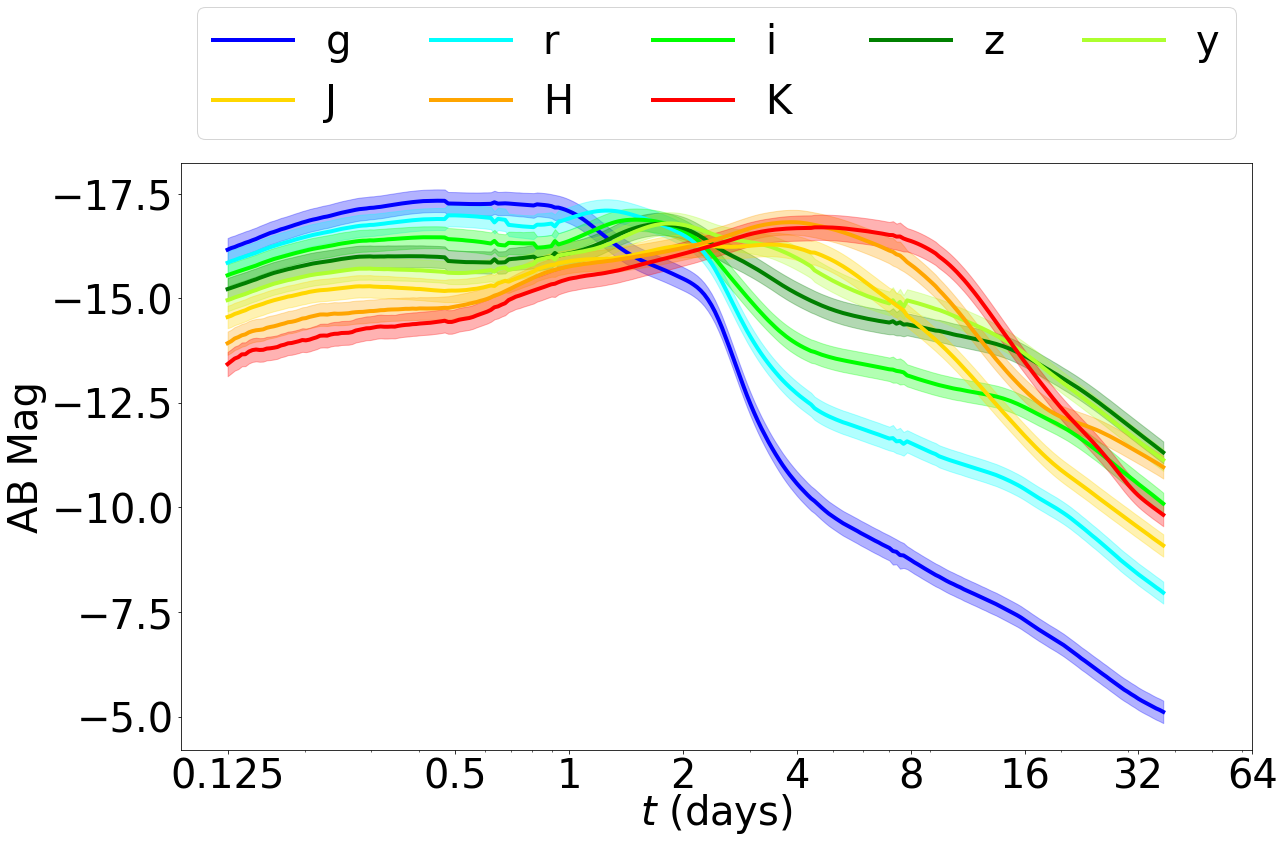

In [2]:
from matplotlib import ticker
import matplotlib.pyplot as plt
import itertools

def flip(items, ncol):
    '''
    credit to Avaris on StackOverflow for this function
    '''
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

times = np.logspace(np.log10(0.125), np.log10(37.239195485411194), 264)

colors = {"g": "blue", "r": "cyan", "i": "lime", "z": "green", "y": "greenyellow", "J": "gold",
         "H": "orange", "K": "red", "S": "darkred"}
wavelengths = 'grizyJHKS'
plt.figure(figsize=(19.2, 10.8))
plt.rc('font', size = 40)
plt.rc('lines', lw=4)
for band in range(lc.shape[1]):
	plt.plot(times, lc[:, band], color=colors[wavelengths[band]], label=wavelengths[band])
	plt.fill_between(times, lc[:, band]-errs[:, band], lc[:, band]+errs[:, band], color=colors[wavelengths[band]], alpha=0.3)
plt.xscale('log')
plt.gca().set_xticks([0.125, 0.5, 1, 2, 4, 8, 16, 32, 64])
plt.gca().get_xaxis().set_major_formatter(ticker.FormatStrFormatter('%g'))
plt.xlabel(r"$t$ (days)", labelpad=-5)
plt.ylabel("AB Mag")
plt.gca().invert_yaxis()
handles, labels = plt.gca().get_legend_handles_labels()
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(flip(handles, 5), flip(labels, 5), ncol=5, bbox_to_anchor=(0.5, 1.3), loc='upper center')
plt.savefig('pred_compact.png')